In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io
import skimage
import scipy.io
import face_alignment

%matplotlib inline

In [9]:
detector = face_alignment.FaceAlignment(face_alignment.LandmarksType._2D, device="cuda")

In [5]:
urls = np.loadtxt("./alldata_urls.txt", dtype=str)
urls[:3]

array([['00001.jpg',
        'http://farm6.static.flickr.com/5474/10041446846_49d351873d_b.jpg'],
       ['00002.jpg',
        'http://farm6.static.flickr.com/5349/10071117213_8ba4d8dc38_b.jpg'],
       ['00003.jpg',
        'http://farm3.static.flickr.com/2894/10073378065_219389c48b_b.jpg']],
      dtype='<U65')

In [3]:
crop_file = np.loadtxt("./crop.txt", dtype=str)
crop_file[:3]

array([['00602.jpg', '0', '998', '9', '758'],
       ['00642.jpg', '0', '1023', '0', '767'],
       ['00473.jpg', '0', '1023', '0', '767']], dtype='<U9')

# Test Single image

In [23]:
def get_image(idx):
    image_id = urls[idx, 0]
    image = io.imread(urls[idx, 1])
    
    for i, row in enumerate(crop_file):
        if row[0] == image_id:
            break
                    
    y1, y2, x1, x2 = crop_file[i, 1:].astype(int)
    return image_id, image[y1:y2, x1:x2, :]

00001.jpg (888, 667, 3)


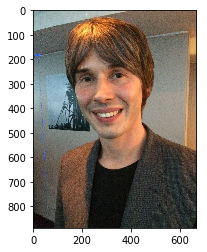

In [25]:
image_id, image = get_image(0)
print(image_id, image.shape)
plt.imshow(image)

In [10]:
def get_face_region(image):
    detected_faces = detector.face_detector.detect_from_image(image.copy())
    if not detected_faces:
        return None
    return detected_faces[0][:4].reshape((2, 2))

In [45]:
face_region = get_face_region(image)
face_region

array([[171.8603 , 128.79361],
       [453.5456 , 527.577  ]], dtype=float32)

In [46]:
def plot_face_region(image, face_region):
    plt.imshow(image)
    plt.plot(
        [face_region[0][0], face_region[1][0], face_region[1][0], face_region[0][0], face_region[0][0]],
        [face_region[0][1], face_region[0][1], face_region[1][1], face_region[1][1], face_region[0][1]],
    )

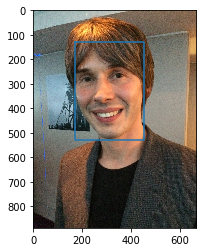

In [47]:
plot_face_region(image, face_region)

In [18]:
def get_mask(image_id):
    mask_file = scipy.io.loadmat("images_mask/{}_mask.mat".format(image_id.replace(".jpg", "")))
    mask = mask_file["mask"]
    return mask

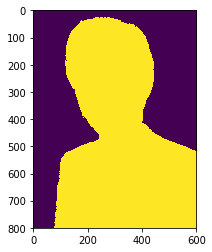

In [19]:
mask = get_mask(image_id)
plt.imshow(mask)

In [58]:
def get_matted_face(image, mask, face_region):
    ih, iw = image.shape[:2]
    mh, mw = mask.shape[:2]
    image = skimage.transform.resize(image, mask.shape)
    masked = np.where(np.expand_dims(mask, axis=-1) == 1, image, np.ones((*mask.shape, 3)))
    
    face_region = face_region * np.array([mw/iw, mh/ih])
    x1, y1, x2, y2 = face_region.flatten()
    hw = int((x2 - x1) * 1.8 * 0.5)
    hh = int((y2 - y1) * 1.8 * 0.5)
    
    cx = int((x1 + x2) * 0.5)
    cy = int((y1 + y2) * 0.5)
    
    xw1 = hw if cx - hw > 0 else cx
    xw2 = hw if cx + hw < mw else mw - cx
    yh1 = hh if cy - hh > 0 else cy
    yh2 = hh if cy + hh < mh else mh - cy
    
    res = np.ones((hh*2, hw*2, 3))
    res[hh-yh1:hh+yh2, hw-xw1:hw+xw2] = masked[cy-yh1:cy+yh2, cx-xw1:cx+xw2]
    
    
    return res

In [59]:
face = get_matted_face(image, mask, face_region)

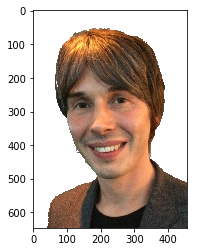

In [60]:
plt.imshow(face)

# Batch Process